# Breast Cancer Classification Pipeline

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.datasets import load_breast_cancer

from sklearn.model_selection import(train_test_split,
cross_val_score,
learning_curve,
validation_curve,
GridSearchCV,
RandomizedSearchCV
) 
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix,roc_auc_score

from scipy.stats import loguniform 
# Set seaborn style
sns.set(style='whitegrid')


### 2. Load Dataset

In [3]:
data=load_breast_cancer() 

X=data.data 
y=data.target

# Target mapping:
# 0 -> Malignant
# 1 -> Benign


 2. TRAIN-TEST SPLIT

In [4]:
X_train,X_test,y_train,y_test=train_test_split(X,y,
train_size=0.2,
random_state=42,
stratify=y
)

3. BASELINE MODEL (BIAS CHECK)

In [9]:
baseline=LogisticRegression(max_iter=2000,solver="liblinear")
baseline_score=cross_val_score(
    baseline,X,y,cv=5,scoring="roc_auc"
).mean()
print(f"Baseline ROC-AUC: {baseline_score:.4f}")

Baseline ROC-AUC: 0.9927


 4. PIPELINES

In [13]:
pipeline_lr=Pipeline([
    ("scaler",StandardScaler()),
    ("model",LogisticRegression(max_iter=500))
])


pipeline_svm=Pipeline([
    ("scaler",StandardScaler()),
    ("model",SVC(probability=True))
])

pipeline_rf = Pipeline([
    ("model", RandomForestClassifier(random_state=42))
])


 5. LEARNING CURVE (BIAS vs VARIANCE)

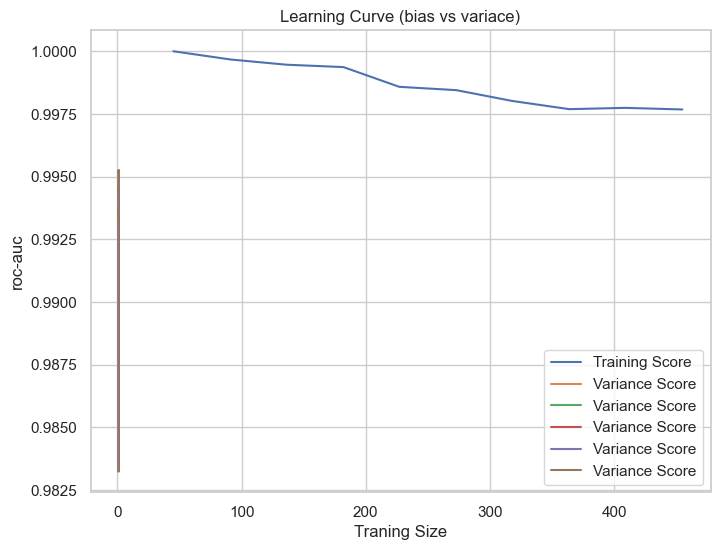

In [17]:
train_sizes,train_scores,val_scores=learning_curve(
    pipeline_lr,
    X,
    y,
    cv=5,
    scoring="roc_auc",
    train_sizes=np.linspace(0.1, 1.0, 10)
)
plt.figure(figsize=(8,6))
plt.plot(train_sizes,train_scores.mean(axis=1),label="Training Score")
plt.plot(train_scores,val_scores.mean(axis=1),label="Variance Score")
plt.xlabel("Traning Size")
plt.ylabel("roc-auc")
plt.title("Learning Curve (bias vs variace)")
plt.savefig("Leaning Curve.png",dpi=300,bbox_inches="tight")
plt.legend()
plt.show()

 6. VALIDATION CURVE (OVERFITTING / UNDERFITTING)

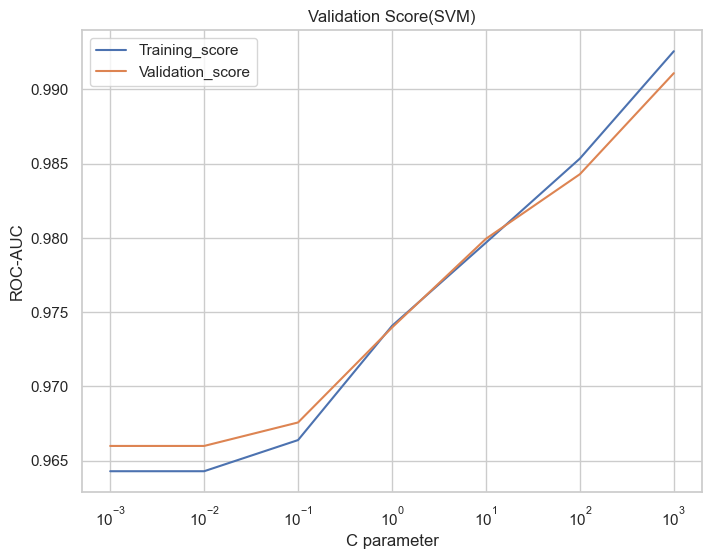

In [19]:
param_range=np.logspace(-3,3,7)
train_scores,val_scores=validation_curve(
    SVC(),
    X,y,
    param_name="C",
    param_range=param_range,
    cv=5,
    scoring="roc_auc"
)

plt.figure(figsize=(8,6))
plt.semilogx(param_range,train_scores.mean(axis=1),label="Training_score")
plt.semilogx(param_range,val_scores.mean(axis=1),label="Validation_score")
plt.xlabel("C parameter")
plt.ylabel("ROC-AUC")
plt.title("Validation Score(SVM)")
plt.savefig("Validation Score.png",dpi=300,bbox_inches="tight")
plt.legend()
plt.show()


### 7. GRID SEARCH (HYPERPARAMETER TUNING)

In [23]:
param_grid={
    "model__C":[0.01,0.1,1,10,100]
}
grid_search=GridSearchCV(
    pipeline_lr,
    param_grid,
    cv=5,
    scoring="roc_auc"
)
grid_search.fit(X_train,y_train)

print("GridSearch Best params:",grid_search.best_params_)
print("GridSearch Best roc_auc:",grid_search.best_score_)

GridSearch Best params: {'model__C': 10}
GridSearch Best roc_auc: 0.9968253968253968


### 8. RANDOM SEARCH (EFFICIENT TUNING)

In [26]:
param_disct={
"model__C":loguniform(0.001,100)
}

random_search=RandomizedSearchCV(
pipeline_lr,
param_disct,
n_iter=20,
cv=5,
scoring="roc_auc",
random_state=42
)
random_search.fit(X_train,y_train)
print("RandomSearch best params:",random_search.best_params_)
print("RandomSearch best score:",random_search.best_score_)

RandomSearch best params: {'model__C': 4.5705630998014515}
RandomSearch best score: 0.9968253968253968


### 9. MODEL COMPARISON (FINAL RESULT)

In [30]:
models={
    "Logistic Regression":pipeline_lr,
    "SVM":pipeline_svm,
    "RandomForest":pipeline_rf
}

result = []
for name, model in models.items():
    model.fit(X_train, y_train)
    prob = model.predict_proba(X_test)[:, 1]
    roc = roc_auc_score(y_test, prob)
    result.append([name, roc])
result_df = pd.DataFrame(result, columns=["Model", "ROC-AUC"])
result_df["ROC-AUC"] = result_df["ROC-AUC"].round(4)

print("The final result")
print(result_df)


The final result
                 Model  ROC-AUC
0  Logistic Regression   0.9913
1                  SVM   0.9907
2         RandomForest   0.9866


 ### 10. VISUAL COMPARISON (SEABORN)

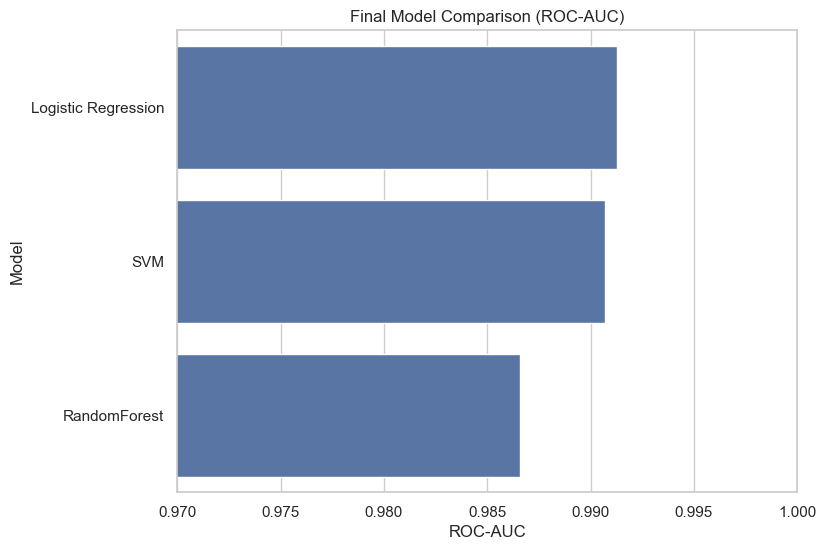

In [31]:
plt.figure(figsize=(8,6))
sns.barplot(x="ROC-AUC",y="Model",data=result_df)
plt.title("Final Model Comparison (ROC-AUC)")
plt.xlim(0.97, 1.0)
plt.show()

### 11. CONFUSION MATRIX (BEST MODEL)

C:\Users\91939\AppData\Local\Temp\ipykernel_19380\756241434.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


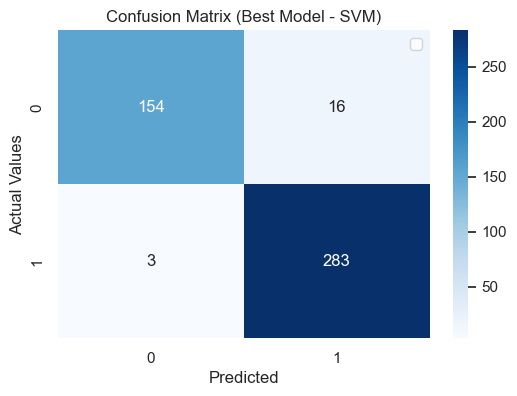


PROJECT EXECUTION COMPLETED SUCCESSFULLY


In [32]:
best_model=pipeline_svm
best_model.fit(X_train,y_train)

cm=confusion_matrix(y_test,best_model.predict(X_test))
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual Values")
plt.title("Confusion Matrix (Best Model - SVM)")
plt.legend()
plt.show()

print("\nPROJECT EXECUTION COMPLETED SUCCESSFULLY")